# SOCIAL ASSISTANCE SPELL IDENTIFICATION AND ANALYSIS
## Derrick Kessie


### Let us import the packages needed for the Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
from scipy.stats import mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, poisson, nbinom

### QUESTION 1
## Please provide code to create an output file with the following format: Each row should correspond to a single spell and include the integrated_case_id and case_id_anon corresponding to the spell, the spell start month, and the spell end month (last month in the spell).

#### Answer

In [2]:
# Read in the data
df = pd.read_csv(r'C:\Users\kwame\Desktop\data analytics\case_fact_sample_100k_anon.csv')

In [3]:
#printout the csv information
df

,extract_month,case_unit_count,integrated_case_id_anon,case_id_anon
0,201411,1,15654,109773
1,201411,1,55338,121197
2,201411,1,46971,71024
3,201411,1,95750,116313
4,201411,1,22308,107380
...,...,...,...,...
1048570,201710,1,15158,13720
1048571,201710,1,4933,91226
1048572,201710,1,40970,133657
1048573,201710,1,19286,44968


In [4]:
# Sort the data by integrated_case_id_anon, case_id_anon and extract_month
df = df.sort_values(by=['integrated_case_id_anon', 'case_id_anon', 'extract_month'])

The above code sorts the data first
- integrated_case_id_anon

then by 
- case_id_anon

and finally by 
- extract_month.

In [5]:
#checking out how the data was sorted
df

,extract_month,case_unit_count,integrated_case_id_anon,case_id_anon
1001009,201711,1,1,49165
1005167,201712,1,1,49165
308133,201801,1,1,49165
856528,201910,1,2,21223
959632,201912,1,2,21223
...,...,...,...,...
1029228,201708,1,105066,46851
304014,201712,1,105066,46851
416685,201805,1,105066,46851
522629,201808,1,105066,46851


In [6]:
# Initialize some variables to keep track of spells
#These variables will help track the spells as I loop through each row.
spells = []
current_spell = {}
last_month = None
last_client = None
last_case = None

In [7]:
# Loop through each row in the data
for index, row in df.iterrows():
    current_month = row['extract_month']
    current_client = row['integrated_case_id_anon']
    current_case = row['case_id_anon']

### Looping through the data
#### For each row, I am  extracting the month of the record, the integrated case ID, and the case ID. 
#### This if condition checks if:
The current client is different from the last client.
The current case is different from the last case.
There's a gap of 2 or more months between the current row and the previous row.
If any of these conditions are true, it means that the current spell (if one exists) has ended.

In [8]:
# Loop through each row in the data
for index, row in df.iterrows():
    current_month = row['extract_month']
    current_client = row['integrated_case_id_anon']
    current_case = row['case_id_anon']

    # If current client or case is different from the last, or there is a gap of 2 or more months
    if current_client != last_client or current_case != last_case or (last_month and current_month - last_month >= 2):
        # If there's a current spell being tracked, save it
        if current_spell:
            spells.append(current_spell)
            current_spell = {}

        current_spell['start_month'] = current_month
        current_spell['integrated_case_id_anon'] = current_client
        current_spell['case_id_anon'] = current_case

    current_spell['end_month'] = current_month
    last_month = current_month
    last_client = current_client
    last_case = current_case

### Handling the Last Spell:
#### After looping through all the rows in the dataset, it's essential to check if there's any remaining spell being tracked but not yet added to our spells list.

In [9]:
# Don't forget to save the last spell if there's one being tracked
if current_spell:
    spells.append(current_spell)

In [10]:
# Convert the list of spells to a DataFrame
spells_df = pd.DataFrame(spells)

In [11]:
# Convert 'start_month' and 'end_month' from YYYYMM format to a date format
spells_df['start_date'] = pd.to_datetime(spells_df['start_month'].astype(str), format='%Y%m')
spells_df['end_date'] = pd.to_datetime(spells_df['end_month'].astype(str), format='%Y%m')


In [12]:
# Calculate difference in months and then add 1 to get the correct spell length
spells_df['spell_length'] = (spells_df['end_date'].dt.year - spells_df['start_date'].dt.year) * 12 + \
                           (spells_df['end_date'].dt.month - spells_df['start_date'].dt.month) + 1



In [13]:
spells_df

,start_month,integrated_case_id_anon,case_id_anon,end_month,start_date,end_date,spell_length
0,201711,1,49165,201712,2017-11-01,2017-12-01,2
1,201801,1,49165,201801,2018-01-01,2018-01-01,1
2,201910,2,21223,201910,2019-10-01,2019-10-01,1
3,201912,2,21223,201912,2019-12-01,2019-12-01,1
4,201411,3,88817,201412,2014-11-01,2014-12-01,2
...,...,...,...,...,...,...,...
320218,201701,105066,46851,201708,2017-01-01,2017-08-01,8
320219,201712,105066,46851,201712,2017-12-01,2017-12-01,1
320220,201805,105066,46851,201805,2018-05-01,2018-05-01,1
320221,201808,105066,46851,201808,2018-08-01,2018-08-01,1


In [14]:
# Drop the temporary 'start_date' and 'end_date' columns if you don't need them
spells_df = spells_df.drop(columns=['start_date', 'end_date'])


In [15]:
spells_df

,start_month,integrated_case_id_anon,case_id_anon,end_month,spell_length
0,201711,1,49165,201712,2
1,201801,1,49165,201801,1
2,201910,2,21223,201910,1
3,201912,2,21223,201912,1
4,201411,3,88817,201412,2
...,...,...,...,...,...
320218,201701,105066,46851,201708,8
320219,201712,105066,46851,201712,1
320220,201805,105066,46851,201805,1
320221,201808,105066,46851,201808,1


In [16]:
# Write the spells DataFrame to a CSV file
spells_df.to_csv(r'C:\Users\kwame\Desktop\data analytics\spells_output.csv', index=False)

The scripts above created the table above.
Each row corresponds to a single spell and include
- the integrated_case_id
- case_id_anon corresponding to the spell
- the spell start month
- and the spell end month 

### QUESTION 2




## What would be the best way to describe the distribution of spell lengths?

#### Answer

#### Approach:

### Numerical Description:
 - Use descriptive statistics, such as mean, median, 
 standard deviation, quartiles, and range, to understand the central
   tendency and dispersion of spell lengths.
 - Visual Representation: Use histograms or kernel density 
plots to visualize the frequency distribution of spell lengths. 
This will provide insights into the shape, spread, and
 central values of the distribution.'''

In [17]:
# Numerical Description of Spell Lengths
spell_length_stats = spells_df['spell_length'].describe()



In [18]:
# Display the statistics
print(f"Count of Spells: {spell_length_stats['count']}")
print(f"25th Percentile of Spell Length: {spell_length_stats['25%']}")
print(f"Median Spell Length: {spell_length_stats['50%']}")
print(f"75th Percentile of Spell Length: {spell_length_stats['75%']}")
print(f"Mean Spell Length: {spell_length_stats['mean']}")
print(f"Standard Deviation of Spell Length: {spell_length_stats['std']}")
print(f"Minimum Spell Length: {spell_length_stats['min']}")
print(f"Maximum Spell Length: {spell_length_stats['max']}")

Count of Spells: 320223.0
25th Percentile of Spell Length: 1.0
Median Spell Length: 2.0
75th Percentile of Spell Length: 5.0
Mean Spell Length: 3.2745149473960335
Standard Deviation of Spell Length: 2.952414991144175
Minimum Spell Length: 1.0
Maximum Spell Length: 12.0


#### From the above statistics, we can observe that 
- a significant portion of spells are short (with 50% being 2 months or shorter). 
-  However, there are also spells of some clients that last up to a year.


#### To get a clearer visual understanding, a histogram 
#### can be plotted to see the distribution of spell lengths. 

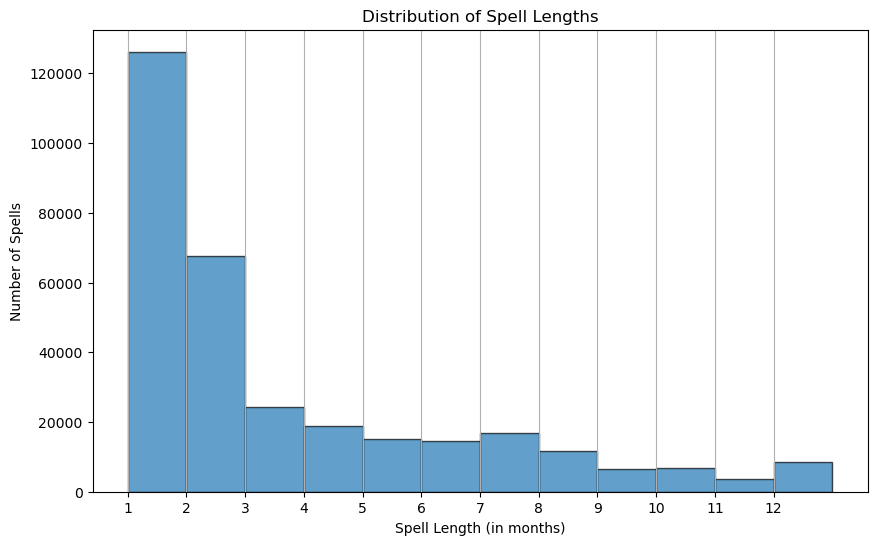

In [19]:
# Plotting a histogram for spell lengths
plt.figure(figsize=(10, 6))
spells_df['spell_length'].hist(bins=range(1, 14), edgecolor='black', alpha=0.7)
plt.title('Distribution of Spell Lengths')
plt.xlabel('Spell Length (in months)')
plt.ylabel('Number of Spells')
plt.xticks(range(1, 13))
plt.grid(axis='y')
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\histogram_spell_length.png')
plt.show()
plt.close()

#### The histogram provides a visual representation of the distribution of spell lengths:

- The majority of spells last for 1 to 2 months with a significant drop as the spell length increases.
- There are fewer spells that last for 3 or more months, but it's notable that there's a small peak around 12 months, indicating a subset of spells that last a full year.

## Are there any inclusion or exclusion criteria related to the 
## data extract that may affect the interpretation of your results 
## or that would be advisable to use?

#### Answer

#### Approach:

- Data Consistency: 
I will check for any missing data
or duplicated rows in the dataset. Such inconsistencies
might artificially create or end spells.


- Data Boundaries: 
For a more visual representation, I will plot a time series
     to see the number of spells starting and ending across 
     the entire dataset.

In [20]:
# Check for missing data
missing_data = spells_df.isnull().sum()

In [21]:
# Check for duplicated rows
duplicated_rows = spells_df.duplicated().sum()

In [22]:
# Count the number of spells starting and ending for each month
start_counts = spells_df.groupby('start_month').size()
end_counts = spells_df.groupby('end_month').size()


In [23]:
print(f"Missing Data: {missing_data}") 

print(f"Duplicated Rows: {duplicated_rows}") 


Missing Data: start_month                0
integrated_case_id_anon    0
case_id_anon               0
end_month                  0
spell_length               0
dtype: int64
Duplicated Rows: 0


The results indicate:

Missing Data: There are no missing values in any of the columns of the dataset.
Duplicated Rows: There are no duplicated rows in the dataset.
Given the absence of missing values and duplicates,
 the data appears consistent in that respect.


Next, I visualized the number of spells starting
 and ending across the entire dataset to gain insights 
 into potential data boundaries or other noticeable patterns.'''

In [24]:
# Count the number of spells starting and ending for each month
start_counts = spells_df.groupby('start_month').size()
end_counts = spells_df.groupby('end_month').size()

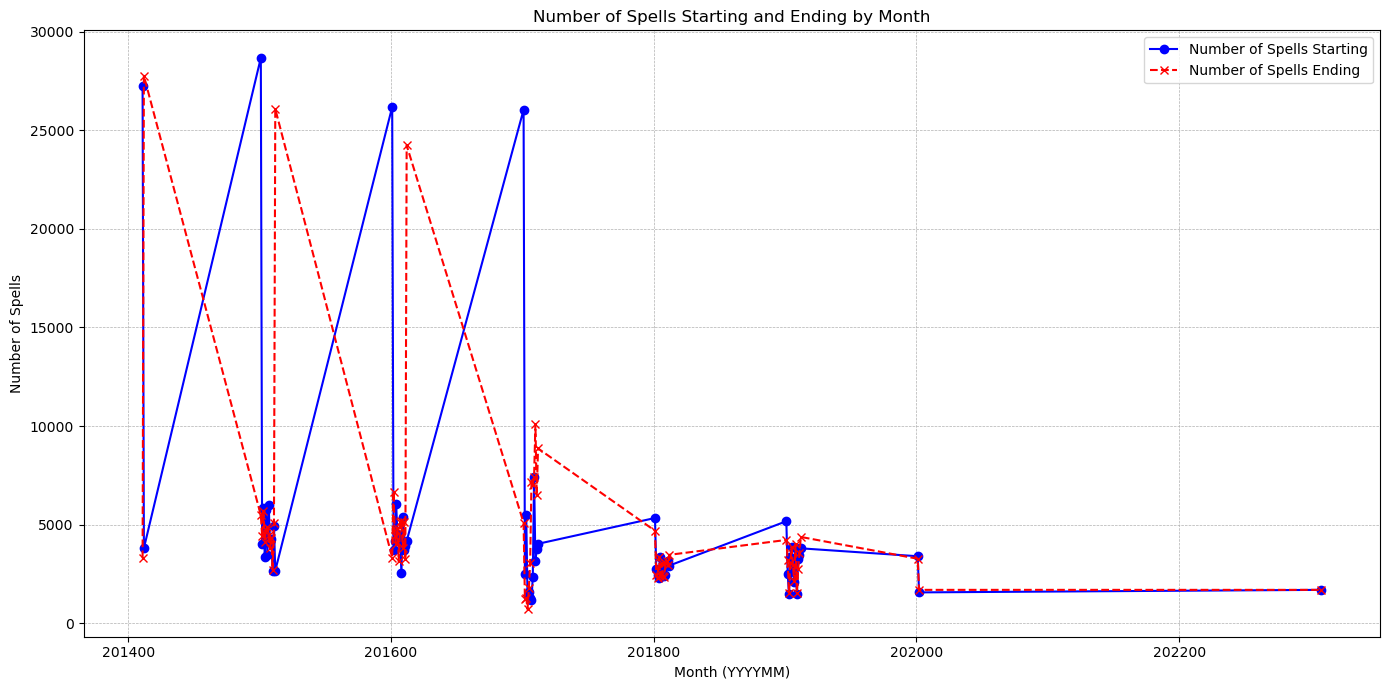

In [25]:
# Plotting the counts
plt.figure(figsize=(14, 7))

start_counts.plot(label='Number of Spells Starting', color='blue', marker='o')
end_counts.plot(label='Number of Spells Ending', color='red', linestyle='--', marker='x')

plt.title('Number of Spells Starting and Ending by Month')
plt.xlabel('Month (YYYYMM)')
plt.ylabel('Number of Spells')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\time_series.png')
plt.show()
plt.close()

### The plot provides a visual representation of the number of spells starting and ending for each month:

- The blue line represents the number of spells starting each month.
- The red dashed line represents the number of spells ending each month.

#### Observations:

There is a relatively consistent number of spells 
starting and ending each month, with some fluctuations.
The number of spells starting in the dataset's first 
few months is notably higher, suggesting that many 
spells might have begun before the dataset's start.
Towards the end of the dataset, there's a decrease
 in the number of spells ending, which could suggest 
 that many spells are ongoing beyond the dataset's end date.

These patterns are crucial to consider when
 interpreting the results as they provide context about 
 potential data boundaries and how they might influence 
 the observed spell lengths

### To  understand the boundaries better, I focused on the spells at the earliest and latest months of the datasets

#### IDENTIFYING THE NUMBER OF SPELLS AT THE EARLIEST START MONTH OF THE DATASET.


In [26]:
# Identify the earliest and latest months in the dataset
earliest_month = spells_df['start_month'].min()


In [27]:
# Extract spells that start at the earliest date and end at the latest date
spells_at_start = spells_df[spells_df['start_month'] == earliest_month]
spells_at_start_count = len(spells_at_start)


In [28]:
print(f"Spells at the start of the dataset: {spells_at_start_count}") #ie the earliest start month which is 201411

Spells at the start of the dataset: 27243


From the analysis:

There are 27,243 spells that start at the
 earliest month in the dataset. This suggests that there 
 are many spells that might have started even before our dataset
   begins, and thus, their true lengths could be longer than what we observe.

I explained it further with a histogram and more statistics


In [29]:
# Extract lengths of spells starting at the dataset's beginning
spells_at_start_lengths = spells_df[spells_df['start_month'] == earliest_month]['spell_length']

In [30]:
# Describe the distribution of these lengths
spells_at_start_lengths_description = spells_at_start_lengths.describe()

In [31]:
# Display the statistics
print(f"Count of Spells at November 2014: {spells_at_start_lengths_description['count']}")
print(f"25th Percentile of Spell Length (November 2014): {spells_at_start_lengths_description['25%']}")
print(f"Median Spell Length (November 2014): {spells_at_start_lengths_description['50%']}")
print(f"75th Percentile of Spell Length (November 2014): {spells_at_start_lengths_description['75%']}")
print(f"Mean Spell Length(November 2014) : {spells_at_start_lengths_description['mean']}")
print(f"Standard Deviation of Spell Length (November 2014): {spells_at_start_lengths_description['std']}")
print(f"Minimum Spell Length (November 2014): {spells_at_start_lengths_description['min']}")
print(f"Maximum Spell Length (November 2014): {spells_at_start_lengths_description['max']}")


Count of Spells at November 2014: 27243.0
25th Percentile of Spell Length (November 2014): 2.0
Median Spell Length (November 2014): 2.0
75th Percentile of Spell Length (November 2014): 2.0
Mean Spell Length(November 2014) : 1.8785743126674743
Standard Deviation of Spell Length (November 2014): 0.32662731951729373
Minimum Spell Length (November 2014): 1.0
Maximum Spell Length (November 2014): 2.0


#### Numerical Description for Spells Starting at Dataset's Beginning:

- Count: There are 27,243 spells that start at the earliest month.
- Mean: The average length of these spells is approximately 1.88 months.
- Standard Deviation: The lengths of these spells have a very low standard
 deviation of about 0.33 months, indicating little variability.
- Minimum and Maximum: All these spells have lengths of 1 or 2 months.
- Median (50th Percentile): Half of these spells are 2 months long.
- 25th and 75th Percentile: Both are 2 months, indicating that a vast
 majority of these spells are of this length.

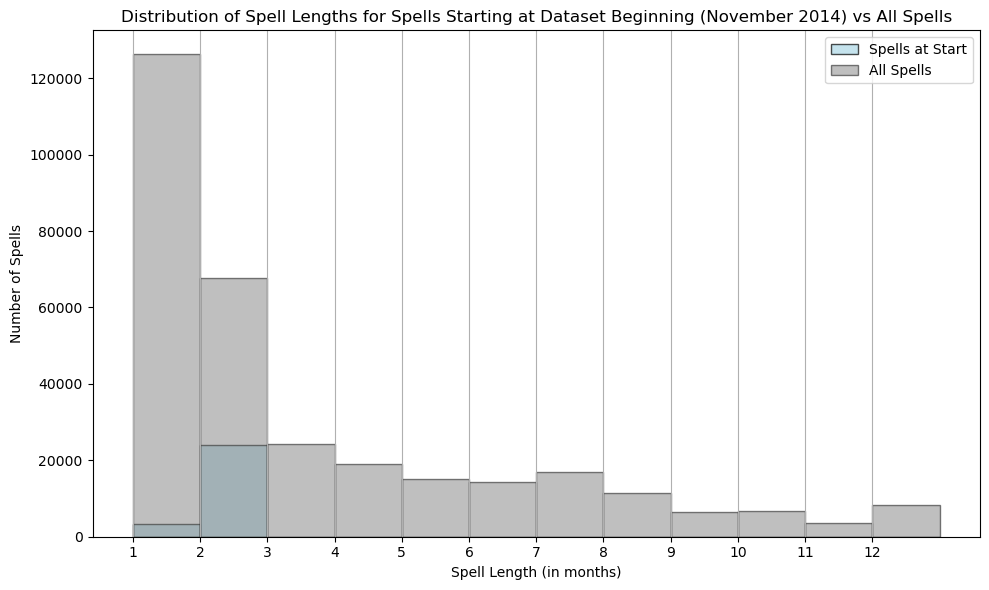

In [32]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
spells_at_start_lengths.hist(bins=range(1, 14), edgecolor='black', alpha=0.7, color='lightblue', label="Spells at Start")
spells_df['spell_length'].hist(bins=range(1, 14), edgecolor='black', alpha=0.5, color='grey', label="All Spells")

plt.title('Distribution of Spell Lengths for Spells Starting at Dataset Beginning (November 2014) vs All Spells')
plt.xlabel('Spell Length (in months)')
plt.ylabel('Number of Spells')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\histogram_Start_spell_length.png')
plt.show()
plt.close()


#### Histogram:

- The light blue bars represent spells that start at the dataset's beginning.
- The grey bars represent all spells in the dataset.


***From these observations, it appears that many spells starting at the dataset's 
beginning are either 1 or 2 months long. Given that these spells start right
 at the dataset's onset, it's likely that many of them began before the
   dataset's start and are much longer than we observe.***



#### IDENTIFYING THE NUMBER OF SPELLS AT THE LATEST END MONTH OF THE DATASET.

In [33]:
latest_month = spells_df['end_month'].max()
spells_at_end = spells_df[spells_df['end_month'] == latest_month]
spells_at_end_count = len(spells_at_end)
print(f"Spells at the end of the dataset: {spells_at_end_count}") #ie the latest end month which is 202308

Spells at the end of the dataset: 1704


There are 1,704 spells that end at the latest month
 in the dataset. These spells could potentially continue 
 beyond the timeframe of our dataset, meaning their true 
 lengths might also be longer than what is recorded.

I explained it further with a histogram and more statistics

In [34]:
# Extract lengths of spells ongoing at the dataset's end
spells_at_end_lengths = spells_df[spells_df['end_month'] == latest_month]['spell_length']

# Describe the distribution of these lengths
spells_at_end_lengths_description = spells_at_end_lengths.describe()

In [35]:
# Display the statistics
print(f"Count of Spells at August 2023: {spells_at_end_lengths_description['count']}")
print(f"25th Percentile of Spell Length (August 2023): {spells_at_end_lengths_description['25%']}")
print(f"Median Spell Length (August 2023): {spells_at_end_lengths_description['50%']}")
print(f"75th Percentile of Spell Length (August 2023): {spells_at_end_lengths_description['75%']}")
print(f"Mean Spell Length(August 2023) : {spells_at_end_lengths_description['mean']}")
print(f"Standard Deviation of Spell Length (August 2023): {spells_at_end_lengths_description['std']}")
print(f"Minimum Spell Length (August 2023): {spells_at_end_lengths_description['min']}")
print(f"Maximum Spell Length (August 2023): {spells_at_end_lengths_description['max']}")


Count of Spells at August 2023: 1704.0
25th Percentile of Spell Length (August 2023): 1.0
Median Spell Length (August 2023): 1.0
75th Percentile of Spell Length (August 2023): 1.0
Mean Spell Length(August 2023) : 1.0
Standard Deviation of Spell Length (August 2023): 0.0
Minimum Spell Length (August 2023): 1.0
Maximum Spell Length (August 2023): 1.0


Numerical Description for Spells Ongoing at Dataset's End:

- Count: There are 1,704 spells that are ongoing at the latest month.- 
- Mean: The average length of these spells is 1 month.
- Standard Deviation: The lengths of these spells have a standard deviation of 0, indicating no variability.
- Minimum and Maximum: All these spells have lengths of 1 month.
- Median (50th Percentile): All of these spells are 1 month long.
- 25th and 75th Percentile: Both are 1 month, further emphasizing that all of these spells are of this length.

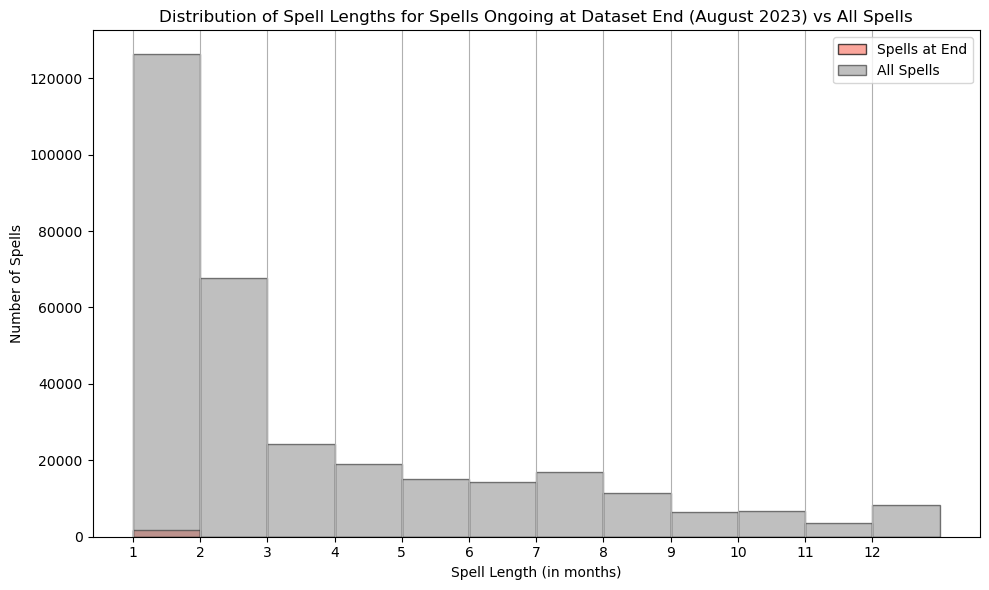

In [36]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
spells_at_end_lengths.hist(bins=range(1, 14), edgecolor='black', alpha=0.7, color='salmon', label="Spells at End")
spells_df['spell_length'].hist(bins=range(1, 14), edgecolor='black', alpha=0.5, color='grey', label="All Spells")

plt.title('Distribution of Spell Lengths for Spells Ongoing at Dataset End (August 2023) vs All Spells')
plt.xlabel('Spell Length (in months)')
plt.ylabel('Number of Spells')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\histogram_End_spell_length.png')
plt.show()
plt.close()


Histogram:

- The salmon-colored bars represent spells that are ongoing at the dataset's end.
- The grey bars represent all spells in the dataset.
Numerical Description for Spells Ongoing at Dataset's End:

These observations suggest that the spells ongoing at the dataset's 
end have only been recorded for 1 month within the dataset's timeframe. 
This means these spells could potentially continue for many more months 
beyond our dataset, affecting our understanding of spell lengths.

***The combined insights from the spells starting at the dataset's
 beginning and those ongoing at the end highlight the potential
   underestimation of many spell lengths due to data truncation at both boundaries.***


## Consider that the beginning of the extract may contain spells already underway. 
## What considerations are relevant near the end of the extract?

#### Answer

#### Approach:

- Beginning of the Extract:
If a spell starts at the very beginning of the dataset, it's possible
 that its actual start could be before the dataset's time range.
   This would imply that the recorded spell length might 
   be an underestimate of the true length.
A potential approach to address this is to mark these 
spells and conduct sensitivity analyses with and without them 
to understand their impact on the overall results.

- End of the Extract:
Similarly, if a spell is ongoing at the end of the dataset, 
its true length might be longer since it could continue
 beyond the dataset's timeframe.
Recognizing these spells is crucial, especially if forecasting
 or making future projections, as truncating these spells can lead to underestimations.'''




***Beginning of the Extract:***

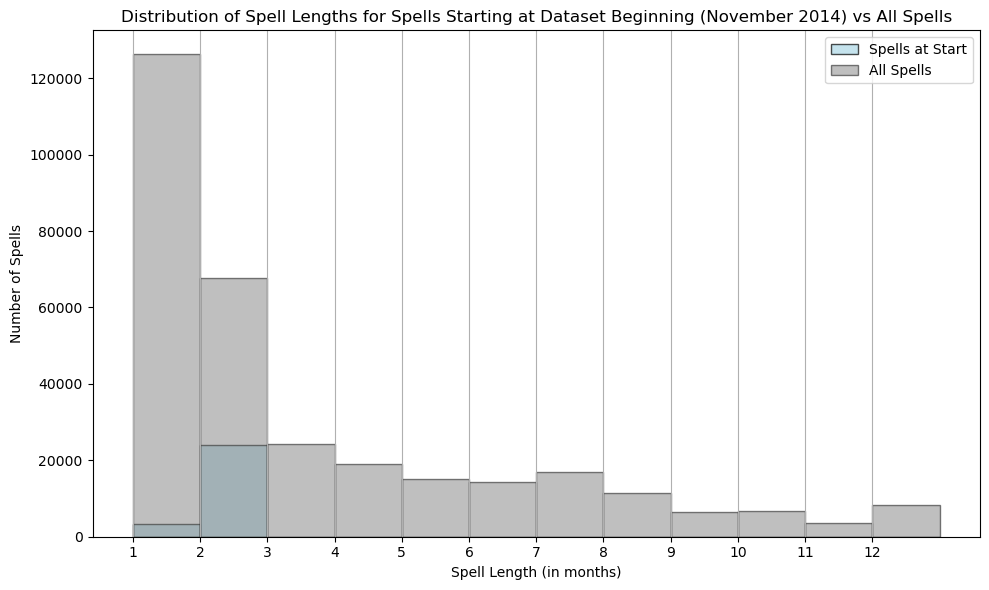

In [37]:
#Lets visualize the begining og the spells again.
# Visualize the distribution
plt.figure(figsize=(10, 6))
spells_at_start_lengths.hist(bins=range(1, 14), edgecolor='black', alpha=0.7, color='lightblue', label="Spells at Start")
spells_df['spell_length'].hist(bins=range(1, 14), edgecolor='black', alpha=0.5, color='grey', label="All Spells")

plt.title('Distribution of Spell Lengths for Spells Starting at Dataset Beginning (November 2014) vs All Spells')
plt.xlabel('Spell Length (in months)')
plt.ylabel('Number of Spells')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\histogram_Start_spell_length.png')
plt.show()
plt.close()

 Next, we can further analyze their impact by
   comparing the overall average spell length
     with and without these spells using sensitivity analysis.

Sensitivity Analysis: By comparing the mean, median, 
and distribution of spell lengths with and without these spells,
 we can gauge their impact on the overall results.'''


In [38]:
# Extract spells not starting at the dataset's beginning
spells_not_at_start = spells_df[spells_df['start_month'] != earliest_month]


In [39]:
# Describe the distribution of spell lengths for all spells and for spells not at the beginning
overall_spell_lengths_description = spells_df['spell_length'].describe()
spells_not_at_start_lengths_description = spells_not_at_start['spell_length'].describe()



In [40]:
# Display the statistics
print(f"Count of Spells not at start: {spells_not_at_start_lengths_description ['count']}")
print(f"25th Percentile of Spell not at start: {spells_not_at_start_lengths_description ['25%']}")
print(f"Median Spell not at start: {spells_not_at_start_lengths_description ['50%']}")
print(f"75th Percentile of Spell not at start: {spells_not_at_start_lengths_description ['75%']}")
print(f"Mean Spell Length not at start: {spells_not_at_start_lengths_description ['mean']}")
print(f"Standard Deviation of Spell not at start: {spells_not_at_start_lengths_description ['std']}")
print(f"Minimum Spell not at start: {spells_not_at_start_lengths_description ['min']}")
print(f"Maximum Spell not at start: {spells_not_at_start_lengths_description ['max']}")


Count of Spells not at start: 292980.0
25th Percentile of Spell not at start: 1.0
Median Spell not at start: 2.0
75th Percentile of Spell not at start: 5.0
Mean Spell Length not at start: 3.404317700866953
Standard Deviation of Spell not at start: 3.052757073085687
Minimum Spell not at start: 1.0
Maximum Spell not at start: 12.0


Numerical Description for All Spells:

- Mean (Average): The average length of a spell is approximately 3.27 months.
- Median (50th Percentile): Half of the spells are 2 months or shorter.
- Numerical Description for Spells Not Starting at the Dataset's Beginning:
- Mean (Average): The average length of a spell, excluding those starting at the dataset's beginning, is approximately 3.40 months.
- Median (50th Percentile): Similar to the overall dataset, half of these spells are 2 months or shorter.


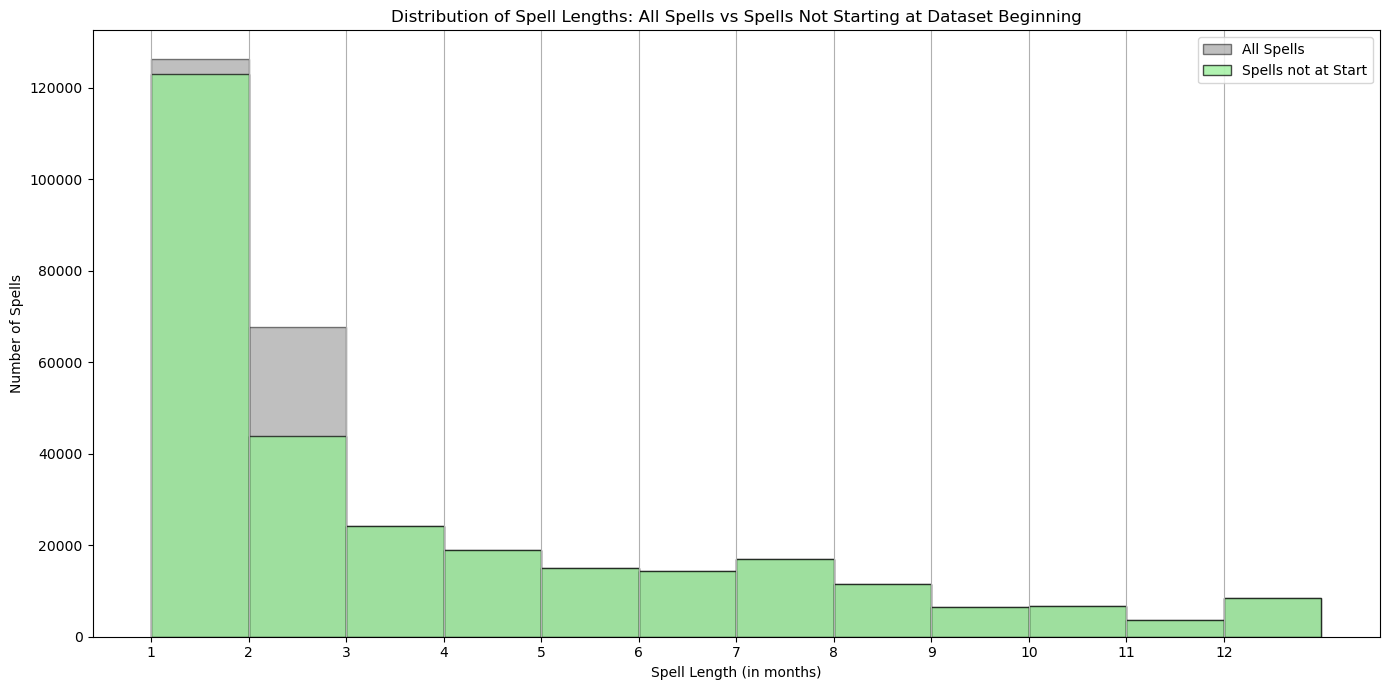

In [41]:
# Visualize the distribution
plt.figure(figsize=(14, 7))

# Histogram for all spells
spells_df['spell_length'].hist(bins=range(1, 14), edgecolor='black', alpha=0.5, color='grey', label="All Spells")
# Histogram for spells not at the beginning
spells_not_at_start['spell_length'].hist(bins=range(1, 14), edgecolor='black', alpha=0.7, color='lightgreen', label="Spells not at Start")

plt.title('Distribution of Spell Lengths: All Spells vs Spells Not Starting at Dataset Beginning')
plt.xlabel('Spell Length (in months)')
plt.ylabel('Number of Spells')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\histogram_All Spells vs Spells Not Starting.png')
plt.show()
plt.close()

From the histogram and the numerical descriptions:

Spells that start at the dataset's beginning seem to be primarily 
of shorter lengths (1-2 months), as reflected in the noticeable peak.
When we exclude these spells, the average spell length slightly 
increases from 3.27 months to 3.40 months.
This underscores the potential underestimation of spell lengths
 due to those starting at the dataset's beginning.

***End of the Extract***

In [42]:
# Extract spells not ongoing at the dataset's end
spells_not_at_end = spells_df[spells_df['end_month'] != latest_month]


In [43]:
# Describe the distribution of spell lengths for all spells and for spells not at the end
spells_not_at_end_lengths_description = spells_not_at_end['spell_length'].describe()


In [44]:
# Display the statistics
print(f"Count of Spells not Ongoing: {spells_not_at_end_lengths_description ['count']}")
print(f"25th Percentile of Spell not Ongoing: {spells_not_at_end_lengths_description ['25%']}")
print(f"Median Spell not Ongoing: {spells_not_at_end_lengths_description ['50%']}")
print(f"75th Percentile of Spell not Ongoing: {spells_not_at_end_lengths_description ['75%']}")
print(f"Mean Spell Length not Ongoing: {spells_not_at_end_lengths_description ['mean']}")
print(f"Standard Deviation of Spell not Ongoing: {spells_not_at_end_lengths_description ['std']}")
print(f"Minimum Spell not Ongoing: {spells_not_at_end_lengths_description ['min']}")
print(f"Maximum Spell not Ongoing: {spells_not_at_end_lengths_description ['max']}")


Count of Spells not Ongoing: 318519.0
25th Percentile of Spell not Ongoing: 1.0
Median Spell not Ongoing: 2.0
75th Percentile of Spell not Ongoing: 5.0
Mean Spell Length not Ongoing: 3.2866830550139867
Standard Deviation of Spell not Ongoing: 2.9555984624572957
Minimum Spell not Ongoing: 1.0
Maximum Spell not Ongoing: 12.0


Numerical Description for Spells Not Ongoing at the Dataset's End:

- Mean (Average): The average length of a spell, 
excluding those ongoing at the dataset's end, is approximately 3.29 months.
- Median (50th Percentile): Half of these spells are 2 months or shorter.
From the histogram and the numerical descriptions:



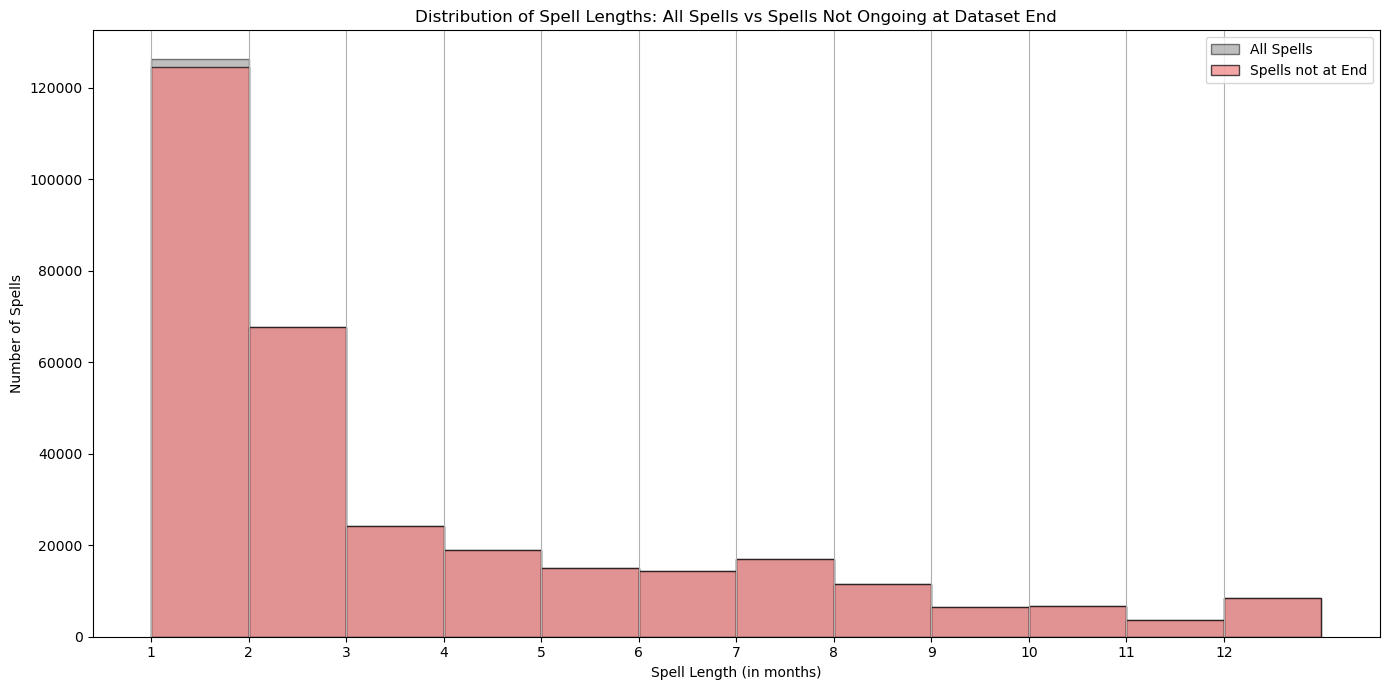

<function matplotlib.pyplot.close(fig=None)>

In [45]:
# Visualize the distribution
plt.figure(figsize=(14, 7))

# Histogram for all spells
spells_df['spell_length'].hist(bins=range(1, 14), edgecolor='black', alpha=0.5, color='grey', label="All Spells")
# Histogram for spells not at the end
spells_not_at_end['spell_length'].hist(bins=range(1, 14), edgecolor='black', alpha=0.7, color='lightcoral', label="Spells not at End")

plt.title('Distribution of Spell Lengths: All Spells vs Spells Not Ongoing at Dataset End')
plt.xlabel('Spell Length (in months)')
plt.ylabel('Number of Spells')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\histogram_All Spells vs Spells Not Ongoing.png')
plt.show()
plt.close


The histogram provides a comparison between the distribution
 of spell lengths for all spells (in grey) and spells not ongoing
   at the dataset's end (in light coral).


From the histogram and the numerical descriptions:

- Spells that are ongoing at the dataset's end are 
primarily of 1-month length, as expected from our earlier analysis.
- When we exclude these spells, the average spell length 
remains fairly consistent, slightly increasing from 3.27 months to 3.29 months.
- This suggests that while the spells at the dataset's end
 might influence the distribution, their impact on the average 
 spell length is not as pronounced as the spells starting at the dataset's beginning.

***These findings emphasize the importance of considering the 
dataset's boundaries when analyzing and interpreting spell lengths.***




### QUESTION 3

#### Is there a statistical difference between the length of first-time spells vs. repeat spells?


##### Answer

#### Approach:

- Data Preparation:

Separate the spells into two groups: "first-time spells" and "repeat spells" for each client.

- Visual Inspection:

Use histograms to visually compare the distributions of the two groups.
Assumption Checks:

- Assumption checks

Check for normality of the two groups using 
methods like the Shapiro-Wilk test.

 Check for equality of variances (homoscedasticity)
 between the two groups using the Levene's test.
Statistical Testing:

If both groups are approximately normally distributed 
and have equal variances, use the independent two-sample t-test.
If assumptions are not met, consider using a non-parametric test like the Mann-Whitney U test.
Interpret Results:

If the p-value is less than a significance level
(often set to 0.05), we reject the null hypothesis and conclude that there's a significant difference in the spell lengths between the two groups.
Let's implement this approach.


***Data Preparation and visualization***

In [46]:
# Create a column to rank spells for each client based on start_month
spells_df['spell_rank'] = spells_df.groupby('integrated_case_id_anon')['start_month'].rank(method='dense')


In [47]:
# Separate the spells into first-time and repeat
first_time_spells = spells_df[spells_df['spell_rank'] == 1]['spell_length']
repeat_spells = spells_df[spells_df['spell_rank'] > 1]['spell_length']


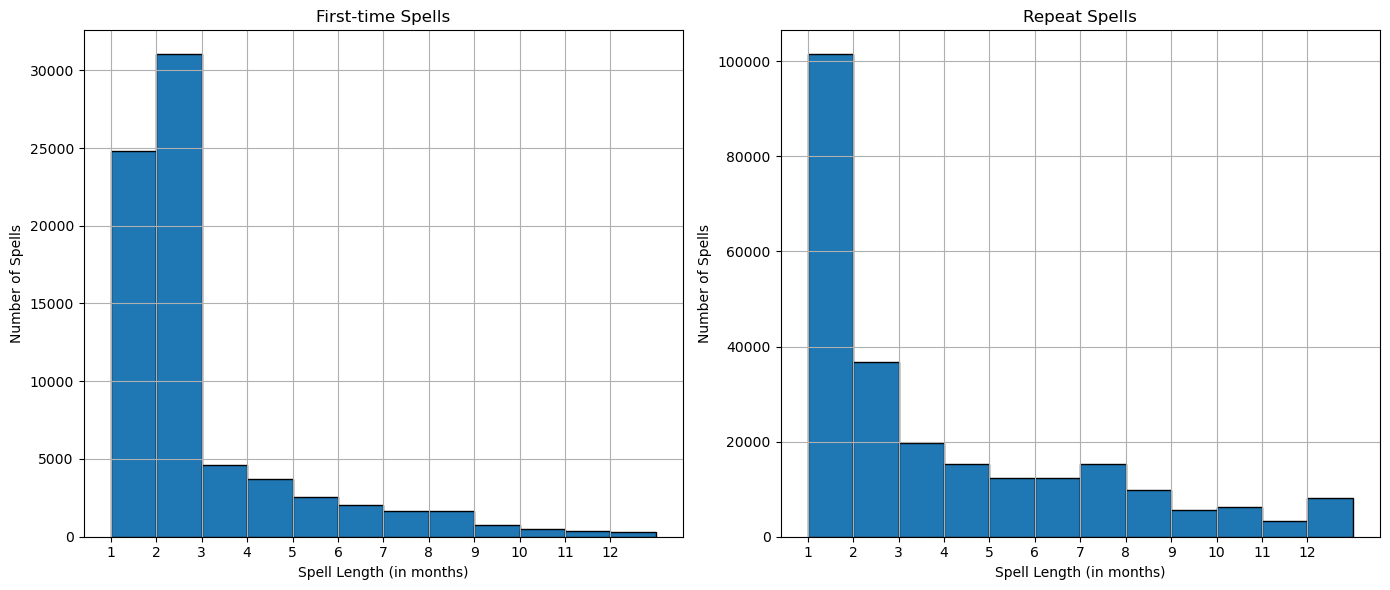

In [48]:
# Plot histograms for visual inspection
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
first_time_spells.hist(edgecolor='black', bins=range(1, 14))
plt.title('First-time Spells')
plt.xlabel('Spell Length (in months)')
plt.ylabel('Number of Spells')
plt.xticks(range(1, 13))

plt.subplot(1, 2, 2)
repeat_spells.hist(edgecolor='black', bins=range(1, 14))
plt.title('Repeat Spells')
plt.xlabel('Spell Length (in months)')
plt.ylabel('Number of Spells')
plt.xticks(range(1, 13))

plt.tight_layout()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\histogram_First timeSpells vs Repeat_Spells.png')
plt.show()
plt.close()


From the plots:
- First-time spells appear to have a higher frequency of shorter durations (1 or 2 months), 
while repeat spells have a more spread out distribution.
- Repeat spells tend to have a broader range of lengths compared to first-time spells.

To formally determine if there's a statistical difference between the two groups,
 we need to check the assumptions of normality and equality of variances before conducting the t-test.'''


***Assumption Checks: Check for normality and equality of variances***

- Normality:
We'll use the Shapiro-Wilk test. If the p-value is less than 0.05,
 it suggests the data is not normally distributed.
- Equality of Variances:
We'll use the Levene's test. If the p-value is less than 0.05, 
it suggests that the groups have unequal variances.

In [49]:
# Assumption Check: Normality
_, p_value_first = shapiro(first_time_spells.sample(1000))  # sample is used due to size limitations of the test
_, p_value_repeat = shapiro(repeat_spells.sample(1000))

In [50]:
normality_results = {
    "Group": ["First-time Spells", "Repeat Spells"],
    "Shapiro-Wilk p-value": [p_value_first, p_value_repeat]
}

In [51]:
# Assumption Check: Equality of Variances (Levene's Test)
_, p_value_levene = levene(first_time_spells, repeat_spells)


In [52]:
normality_df = pd.DataFrame(normality_results)

In [53]:
print(f"Normality Results: {normality_df}")

Normality Results:                Group  Shapiro-Wilk p-value
0  First-time Spells          1.002239e-38
1      Repeat Spells          1.643061e-33


Normality:

For both first-time spells and repeat spells, the p-values from the
 Shapiro-Wilk test are significantly less than 0.05. This indicates that neither
   group is normally distributed.

In [54]:
print(f"P-Value: {p_value_levene}")

P-Value: 0.0


Equality of Variances:

The p-value from the Levene's test is 0.0, suggesting that 
the variances between the two groups are not equal (homoscedasticity is violated).

***Given the violations of both normality and equality of variances,
 the traditional independent two-sample t-test may not be appropriate. 
 Instead, I considered using the non-parametric Mann-Whitney U test,
   which does not make these assumptions.***

In [55]:
# Mann-Whitney U Test
u_statistic, p_value_mannwhitney = mannwhitneyu(first_time_spells, repeat_spells, alternative='two-sided')


In [56]:
# Display the statistics
print(f"U-Statistics: {u_statistic}")


U-Statistics: 8236255561.0


In [57]:
print(f"p-value: {p_value_mannwhitney}")

p-value: 0.0


The p-value is less than the commonly used significance level of 0.05,
 indicating that we can reject the null hypothesis.
   This means that there is a statistically significant difference
     in the lengths of first-time spells and repeat spells.
     

***In summary, based on the Mann-Whitney U test, there's evidence
 to suggest that the length of first-time spells is statistically
   different from that of repeat spells.***

### QUESTION 4

#### Please describe the distribution of gaps between spells (remember, 1-month-long gaps are not considered spell gaps). Is there a difference between gaps that result in a new case_id_anon and gaps that do not?

#### Answer

#### Approach:

- Data Preparation:
Calculate the gaps between consecutive spells for each client.
Identify if the gap resulted in a new case_id_anon or not.
Visual Inspection:

- Visualisations

Plot histograms or kernel density plots for gaps associated
 with a new case_id_anon and those without.
Statistical Testing:

- Statistical Differences
Check for statistical differences between the two groups using
 appropriate tests, based on distribution assumptions.
Interpret Results:

Based on visual and statistical results, provide a description 
of the distribution of gaps and determine if there's a significant 
difference between the two gap types.
Let's start with the data preparation step to calculate the gaps 
between spells and identify the type of gap.'''



***Calculate the gaps and identify gap types as before***

In [58]:
# Create a new column to store the start month of the next spell for each client
spells_df['next_start_month'] = spells_df.groupby('integrated_case_id_anon')['start_month'].shift(-1)


In [59]:
# Calculate the gap between the end of the current spell and the start of the next spell
spells_df['gap'] = spells_df['next_start_month'] - spells_df['end_month']


In [60]:
# Create a new column to store the case_id_anon of the next spell for each client
spells_df['next_case_id_anon'] = spells_df.groupby('integrated_case_id_anon')['case_id_anon'].shift(-1)


In [61]:
# Identify if the gap resulted in a new case_id_anon or not
spells_df['new_case_gap'] = spells_df['case_id_anon'] != spells_df['next_case_id_anon']


In [62]:
spells_df

,start_month,integrated_case_id_anon,case_id_anon,end_month,spell_length,spell_rank,next_start_month,gap,next_case_id_anon,new_case_gap
0,201711,1,49165,201712,2,1.0,201801.0,89.0,49165.0,False
1,201801,1,49165,201801,1,2.0,NaN,NaN,NaN,True
2,201910,2,21223,201910,1,1.0,201912.0,2.0,21223.0,False
3,201912,2,21223,201912,1,2.0,NaN,NaN,NaN,True
4,201411,3,88817,201412,2,1.0,201501.0,89.0,88817.0,False
...,...,...,...,...,...,...,...,...,...,...
320218,201701,105066,46851,201708,8,4.0,201712.0,4.0,46851.0,False
320219,201712,105066,46851,201712,1,5.0,201805.0,93.0,46851.0,False
320220,201805,105066,46851,201805,1,6.0,201808.0,3.0,46851.0,False
320221,201808,105066,46851,201808,1,7.0,201905.0,97.0,46851.0,False


In [63]:
# Filter out 1-month-long gaps
gaps_df = spells_df[spells_df['gap'] > 1]


In [64]:
gaps_df[['gap', 'new_case_gap']].head()



,gap,new_case_gap
0,89.0,False
2,2.0,False
4,89.0,False
5,2.0,False
7,2.0,False


In [65]:
gaps_df

,start_month,integrated_case_id_anon,case_id_anon,end_month,spell_length,spell_rank,next_start_month,gap,next_case_id_anon,new_case_gap
0,201711,1,49165,201712,2,1.0,201801.0,89.0,49165.0,False
2,201910,2,21223,201910,1,1.0,201912.0,2.0,21223.0,False
4,201411,3,88817,201412,2,1.0,201501.0,89.0,88817.0,False
5,201501,3,88817,201503,3,2.0,201505.0,2.0,88817.0,False
7,201705,4,10767,201707,3,1.0,201709.0,2.0,10767.0,False
...,...,...,...,...,...,...,...,...,...,...
320217,201606,105066,46851,201612,7,3.0,201701.0,89.0,46851.0,False
320218,201701,105066,46851,201708,8,4.0,201712.0,4.0,46851.0,False
320219,201712,105066,46851,201712,1,5.0,201805.0,93.0,46851.0,False
320220,201805,105066,46851,201805,1,6.0,201808.0,3.0,46851.0,False


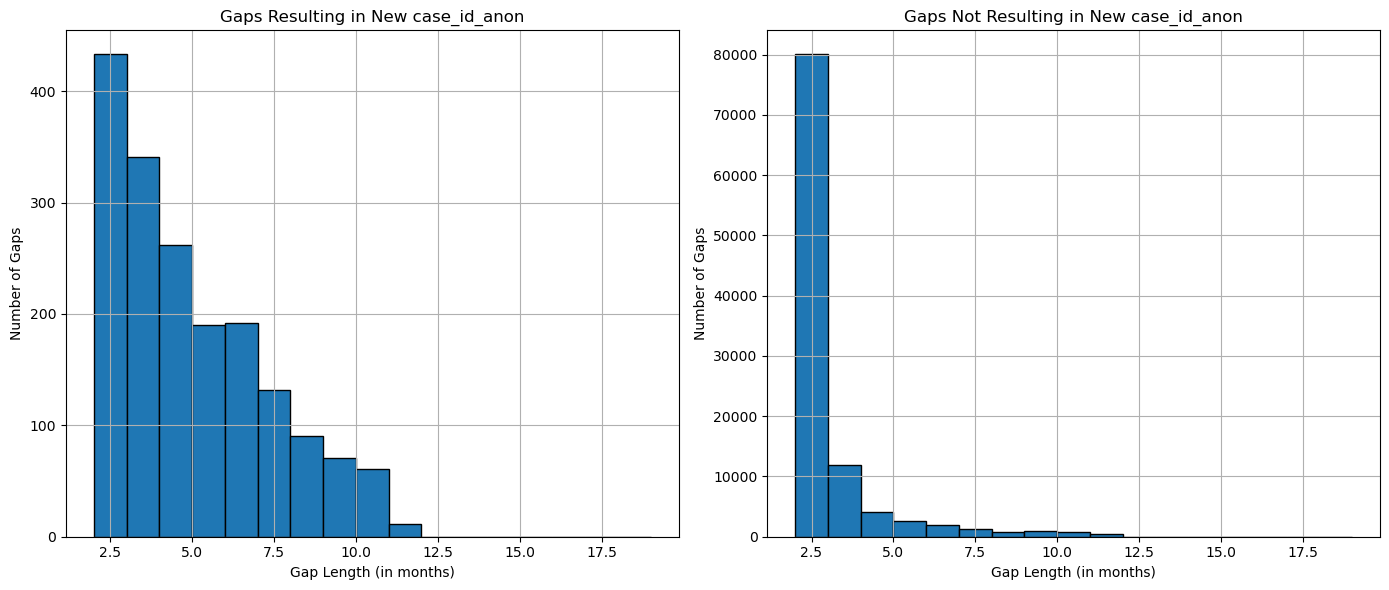

In [66]:
plt.figure(figsize=(14, 6))

# Gaps that resulted in a new case_id_anon
plt.subplot(1, 2, 1)
gaps_df[gaps_df['new_case_gap']]['gap'].hist(edgecolor='black', bins=range(2, 20))
plt.title('Gaps Resulting in New case_id_anon')
plt.xlabel('Gap Length (in months)')
plt.ylabel('Number of Gaps')

# Gaps that did not result in a new case_id_anon
plt.subplot(1, 2, 2)
gaps_df[~gaps_df['new_case_gap']]['gap'].hist(edgecolor='black', bins=range(2, 20))
plt.title('Gaps Not Resulting in New case_id_anon')
plt.xlabel('Gap Length (in months)')
plt.ylabel('Number of Gaps')

plt.tight_layout()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\histogram_gaps.png')
plt.show()
plt.close()

- Left (Gaps Resulting in New case_id_anon):

This histogram displays the frequency of gaps that resulted in a new case_id_anon.
Most of the gaps appear to be 2 months long, with fewer occurrences of longer gaps.

- Right (Gaps Not Resulting in New case_id_anon):

This histogram shows the frequency of gaps that did not result in a new case_id_anon.
Again, most of the gaps are 2 months long. 
There are fewer occurrences of gaps longer than 2 months, 
and they decrease in frequency as gap length increases.

From a visual inspection, both distributions seem similar,
 with the majority of gaps being 2 months long. 
 
 ***However, to confirm if there's a statistically significant difference
   between the two types of gaps, we should conduct a statistical test.***


Given that the distribution of gap lengths is not normally distributed (as evident from the histograms), we'll use the non-parametric Mann-Whitney U test to compare the two groups of gaps. This test is suitable for comparing two independent samples when the normality assumption is not met.

Hypotheses:
- Null Hypothesis (H0): There's no difference in the distribution of gap lengths
 between gaps that result in a new case_id_anon and those that don't.
- Alternative Hypothesis (H1): There's a difference in the distribution of gap lengths
 between the two groups

In [67]:
# Extract gap lengths for the two types of gaps
gaps_new_case = gaps_df[gaps_df['new_case_gap']]['gap']
gaps_no_new_case = gaps_df[~gaps_df['new_case_gap']]['gap']


In [68]:
# Perform the Mann-Whitney U test again
u_statistic, p_value = mannwhitneyu(gaps_new_case, gaps_no_new_case, alternative='two-sided')


In [69]:

print(f"U Statistics for gap length: {u_statistic}")


U Statistics for gap length: 1537533763.5


In [70]:
print(f"P value for gap length: {p_value}")


P value for gap length: 0.0


In [71]:
# Write the spells DataFrame to a CSV file
gaps_df.to_csv(r'C:\Users\kwame\Desktop\data analytics\gaps_output.csv', index=False)



### QUESTION 5

#### What distribution could best describe the number of spells per client?

### Answer

#### Approach
To determine what distribution best describes the number of spells per client, I will :

- Calculate the Number of Spells per Client: 

- Group by the client ID and count the number of spells for each client.

- Visual Inspection: Plot the histogram of the number of spells per client to visually inspect the distribution.

- Fit Distributions: Based on the visual inspection, I will fit a few likely distributions (e.g., Poisson, negative binomial) and assess their goodness-of-fit.

In [72]:
# Calculate the number of spells per client again
spells_per_client = gaps_df.groupby('integrated_case_id_anon').size()


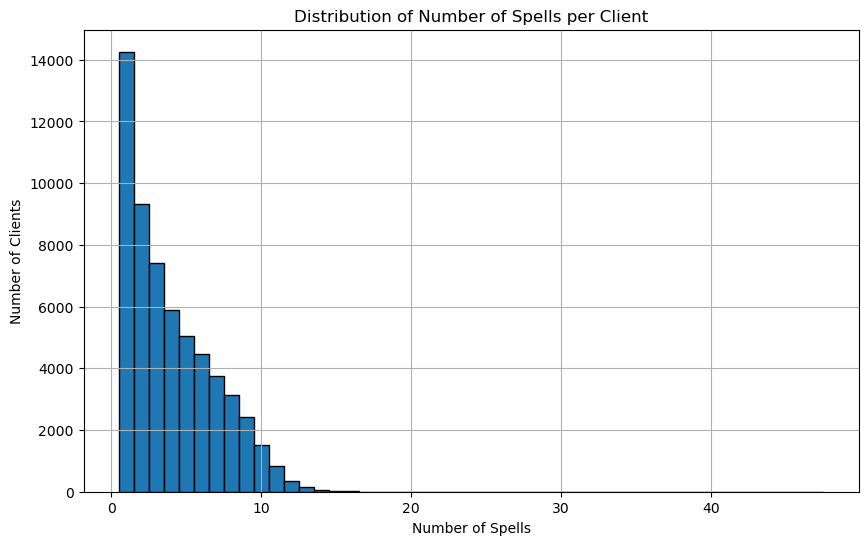

In [73]:
# Visualize the distribution of the number of spells per client again
plt.figure(figsize=(10, 6))
spells_per_client.hist(bins=range(1, spells_per_client.max() + 1), edgecolor='black', align='left')
plt.title('Distribution of Number of Spells per Client')
plt.xlabel('Number of Spells')
plt.ylabel('Number of Clients')
plt.show()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\histogram_spell_per_client.png')
plt.close()

From the visualization, we can observe the following:

- The majority of clients have only one spell.
- The number of clients tends to decrease as the number of spells increases.
- The distribution appears to be right-skewed, which suggests that it mightbe well-described by a Poisson distribution or a negative binomial distribution.

   The Poisson distribution is typically used for modeling the number of times
     an event occurs within a fixed interval, while the negative binomial distribution 
     is used when the number of successes is fixed and we're 
     counting the number of failures before the last success.

In [74]:
# Calculate the number of spells per client
spells_per_client = gaps_df.groupby('integrated_case_id_anon').size()


In [75]:
# Poisson distribution parameter
lambda_poisson = spells_per_client.mean()


In [76]:
# Estimate parameters for the negative binomial distribution using method of moments
mean_spells = spells_per_client.mean()
var_spells = spells_per_client.var()


In [77]:
p_nbinom = mean_spells / var_spells
r_nbinom = mean_spells * p_nbinom / (1 - p_nbinom)


In [78]:
# Generate expected distributions
x = np.arange(1, spells_per_client.max() + 1)
y_poisson = poisson.pmf(x, lambda_poisson) * len(spells_per_client)
y_nbinom_mom = nbinom.pmf(x, r_nbinom, p_nbinom) * len(spells_per_client)


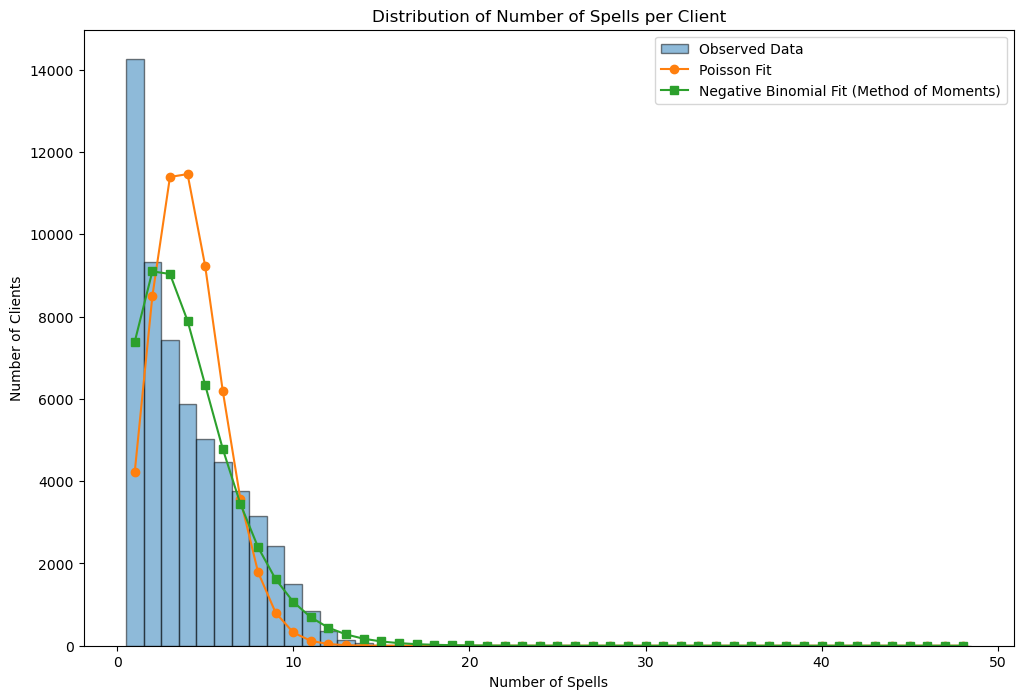

<Figure size 640x480 with 0 Axes>

In [79]:
# Plotting the distributions
plt.figure(figsize=(12, 8))

# Observed data
plt.hist(spells_per_client, bins=range(1, spells_per_client.max() + 2), 
         edgecolor='black', align='left', alpha=0.5, label='Observed Data')

# Expected data
plt.plot(x, y_poisson, 'o-', label='Poisson Fit')
plt.plot(x, y_nbinom_mom, 's-', label='Negative Binomial Fit (Method of Moments)')

plt.title('Distribution of Number of Spells per Client')
plt.xlabel('Number of Spells')
plt.ylabel('Number of Clients')
plt.legend()
plt.show()
plt.savefig(r'C:\Users\kwame\Desktop\data analytics\poisson_nbinom.png')
plt.show()
plt.close()

- Observed Data (Histogram): 
This represents the actual number of spells per client from the dataset.

- Poisson Fit (Blue Dots): 
The expected number of clients for each spell count based on the Poisson distribution.
- Negative Binomial Fit (Orange Squares): 
The expected number of clients for each spell count based on 
the negative binomial distribution (fitted using the method of moments).
From the visualization:


Both the Poisson and Negative Binomial distributions seem
 to capture the decline in the number of clients as the number of spells increases.
The Negative Binomial distribution seems to fit the
 data slightly better than the Poisson, especially 
 for clients with more spells.
 
***Given this visual inspection, the Negative 
Binomial distribution might be a better choice to
 describe the number of spells per client in this dataset.***